In [235]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [236]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [237]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [238]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.7622549  0.7120098  0.71691176 0.72760736 0.77272727 0.76904177
 0.72727273 0.74447174 0.76412776 0.74692875]
0.744335385712145


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

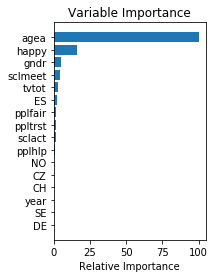

In [239]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [240]:
# For easy loading...
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


#### Step 1 of 5: Creating New Features

In [241]:
df.nunique()

cntry         6
idno       3076
year          2
tvtot         8
ppltrst      11
pplfair      11
pplhlp       11
happy        11
sclmeet       7
sclact        5
gndr          2
agea         83
partner       2
dtype: int64

Observing the above, the year and gender are categorical variable. Therefore, we should make these features into dummies so that they aren't treated with incremental value.

In [242]:
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno','year','gndr'])]

# Make the categorical variable 'country' into dummies as well as 'year' and 'gndr' into binary categoricals
X = pd.concat([X, pd.get_dummies(df[['cntry']])], axis=1)
X['male'] = np.where(df["gndr"] == 2, 1, 0)
X['second_year'] = np.where(df["year"] == 7, 1, 0)
X.head()

,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,cntry_CH,cntry_CZ,cntry_DE,cntry_ES,cntry_NO,cntry_SE,male,second_year
0,3.0,3.0,10.0,5.0,8.0,5.0,4.0,60.0,1,0,0,0,0,0,1,0
1,6.0,5.0,7.0,5.0,9.0,3.0,2.0,59.0,1,0,0,0,0,0,1,0
2,1.0,8.0,8.0,8.0,7.0,6.0,3.0,24.0,1,0,0,0,0,0,0,0
3,4.0,6.0,6.0,7.0,10.0,6.0,2.0,64.0,1,0,0,0,0,0,1,0
4,5.0,6.0,7.0,5.0,8.0,7.0,2.0,55.0,1,0,0,0,0,0,1,0


Observing the correlation below, the second highest (and highest *positive*) one-to-one variable correlation with the partner-target variable is with 'sclmeet', their level of social interaction. Let's dig a little further.

In [244]:
# Observing correlation effect, squaring this feature increases the correlation percentage by over 1 percent. 
X['sclmeet_squared'] = X.sclmeet ** 2

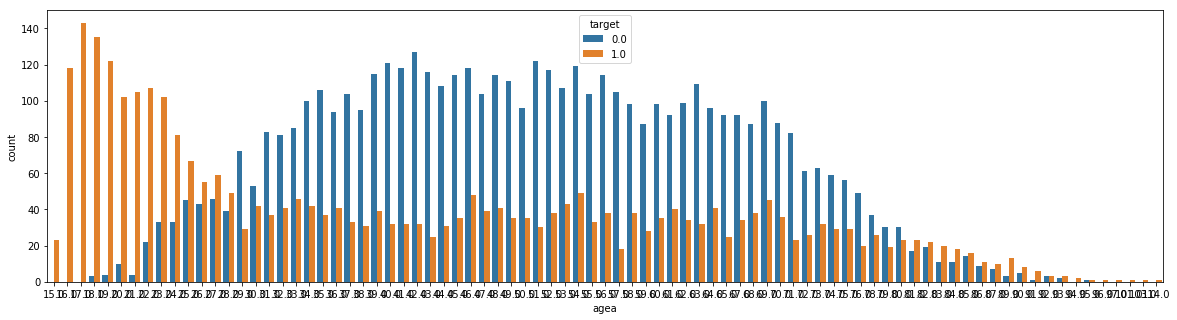

In [245]:
# Observing age affect on target
X['target'] = y

plt.figure(figsize=(20,5))
sns.countplot(x='agea', hue='target', data=X)
plt.show()

X = X.drop('target', 1)

In [246]:
# Creating categorical variable for the high-target age group below 23
X['younger_than_23'] = np.where(X.agea < 23, 1, 0)
y[X.younger_than_23 == 1].mean()

0.9521158129175946

In [247]:
X['age_times_happy'] = X.agea * X.happy

In [248]:
X['target'] = y
X.corr()

,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,cntry_CH,cntry_CZ,cntry_DE,cntry_ES,cntry_NO,cntry_SE,male,second_year,sclmeet_squared,younger_than_23,age_times_happy,target
tvtot,1.000000,-0.142422,-0.119277,-0.069080,-0.118598,-0.078864,-0.092375,0.257674,-0.173825,0.218606,0.004144,0.035985,-0.017619,-0.050075,0.017922,-0.031596,-0.077242,-0.109670,0.159138,-0.028816
ppltrst,-0.142422,1.000000,0.597506,0.459250,0.231533,0.122555,0.137491,-0.029412,0.031936,-0.225021,-0.009180,-0.152500,0.217530,0.132684,-0.029921,-0.001600,0.113109,0.012685,0.093452,-0.034371
pplfair,-0.119277,0.597506,1.000000,0.480931,0.247755,0.096501,0.128808,0.014724,0.058250,-0.215494,0.005904,-0.188744,0.191488,0.161542,0.022251,0.004283,0.083597,0.018556,0.142029,-0.034054
pplhlp,-0.069080,0.459250,0.480931,1.000000,0.215323,0.080489,0.092673,0.040351,0.079003,-0.166372,0.003274,-0.223920,0.153183,0.173921,0.042046,-0.032901,0.072531,0.021953,0.146244,-0.022069
happy,-0.118598,0.231533,0.247755,0.215323,1.000000,0.182944,0.192030,-0.042970,0.110593,-0.206445,-0.003884,-0.074060,0.100777,0.063745,-0.022413,-0.013378,0.172120,0.064411,0.473904,-0.145061
sclmeet,-0.078864,0.122555,0.096501,0.080489,0.182944,1.000000,0.283319,-0.194443,-0.021595,-0.174738,-0.022014,0.011601,0.070484,0.097158,0.009533,-0.028502,0.985043,0.192910,-0.075821,0.162970
sclact,-0.092375,0.137491,0.128808,0.092673,0.192030,0.283319,1.000000,-0.059442,-0.004271,-0.038131,0.003764,-0.107427,0.080589,0.080040,-0.031648,0.012150,0.268370,0.064411,0.053886,0.011405
agea,0.257674,-0.029412,0.014724,0.040351,-0.042970,-0.194443,-0.059442,1.000000,-0.015258,-0.033002,0.030541,0.010583,-0.023270,0.048733,0.020598,-0.003520,-0.200770,-0.546374,0.838211,-0.256670
cntry_CH,-0.173825,0.031936,0.058250,0.079003,0.110593,-0.021595,-0.004271,-0.015258,1.000000,-0.196084,-0.027113,-0.294179,-0.216024,-0.243774,0.013925,0.003218,-0.035229,0.017730,0.040859,-0.019266
cntry_CZ,0.218606,-0.225021,-0.215494,-0.166372,-0.206445,-0.174738,-0.038131,-0.033002,-0.196084,1.000000,-0.024048,-0.260926,-0.191605,-0.216219,0.024788,0.001472,-0.168655,-0.004459,-0.137669,0.033158


In [249]:
X = X.drop('target', 1)

#### Overfitting-Prevention through Subsampling

In [250]:
from sklearn.model_selection import cross_val_score

In [251]:
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [252]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [253]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.77205882 0.73284314 0.71446078 0.72883436 0.77395577 0.76904177
 0.73341523 0.74815725 0.77272727 0.74324324]
0.74887376414668


The addition of the new feature ('agea_times_happy') increases the accuracy by 0.4%.

#### Changing Iterations
##### 750 Iterations

In [254]:
# Adjusting number of estimators from 500 to 750
params = {'n_estimators': 750,
          'max_depth': 2,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=750,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [255]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.77205882 0.73651961 0.70833333 0.72760736 0.77149877 0.77149877
 0.73341523 0.74570025 0.76658477 0.74570025]
0.7478917161067107


##### 1000 Iterations

In [256]:
# Adjusting number of estimators from 500 to 1000
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [257]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.76960784 0.73529412 0.70955882 0.73128834 0.77027027 0.77027027
 0.74201474 0.72113022 0.76289926 0.73955774]
0.7451891634014516


There is greater variance in the scores, strongly suggesting overfitting for certain subsets and causing problems in others.

#### Different Loss Function

In [258]:
# Adjusting loss function from 'deviance' to 'exponential'
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'exponential'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [259]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.76838235 0.70588235 0.71323529 0.72392638 0.77395577 0.77027027
 0.73587224 0.74324324 0.77149877 0.74570025]
0.7451966920908639


The loss function adjustment doesn't seem to affect the accuracy of the model.

#### Adjusting Weak-Learner Structure

In [260]:
# Adjusting max-depth from '2' to '3'
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [261]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.75980392 0.71691176 0.69240196 0.72515337 0.77027027 0.76658477
 0.73955774 0.65356265 0.74570025 0.74692875]
0.7316875443896376


In [262]:
# Adjusting max-depth from '2' to '4'
params = {'n_estimators': 500,
          'max_depth': 4,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [263]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.77328431 0.71078431 0.67892157 0.72515337 0.75921376 0.75552826
 0.73710074 0.57739558 0.74938575 0.74324324]
0.7210010892178882


In [264]:
# Adding 'warm_start' parameter
params = {'n_estimators': 500,
          'max_depth': 2,
          'warm_start': True,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=True)

In [265]:
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.77205882 0.73284314 0.71446078 0.72883436 0.77395577 0.76904177
 0.73341523 0.74815725 0.77149877 0.74324324]
0.74875091402383


#### Conclusions

After adjusting the different settings and observing their results on the accuracy of the model on the test set, the results showed that the only adjustment that seemed to make a considerable difference was in the creation of new features.